In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import patches from matplotlib to make custom legend
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import glob

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}

In [12]:
handles = [
    Line2D([0], [0], marker='o', color='w', label='LGBMClassifier', markerfacecolor='C0', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='FairGBMClassifier', markerfacecolor='C1', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='FairClassifier', markerfacecolor='C2', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MMBFair', markerfacecolor='C3', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MMBFair_grad', markerfacecolor='C4', markersize=10),
]

## experiment 1

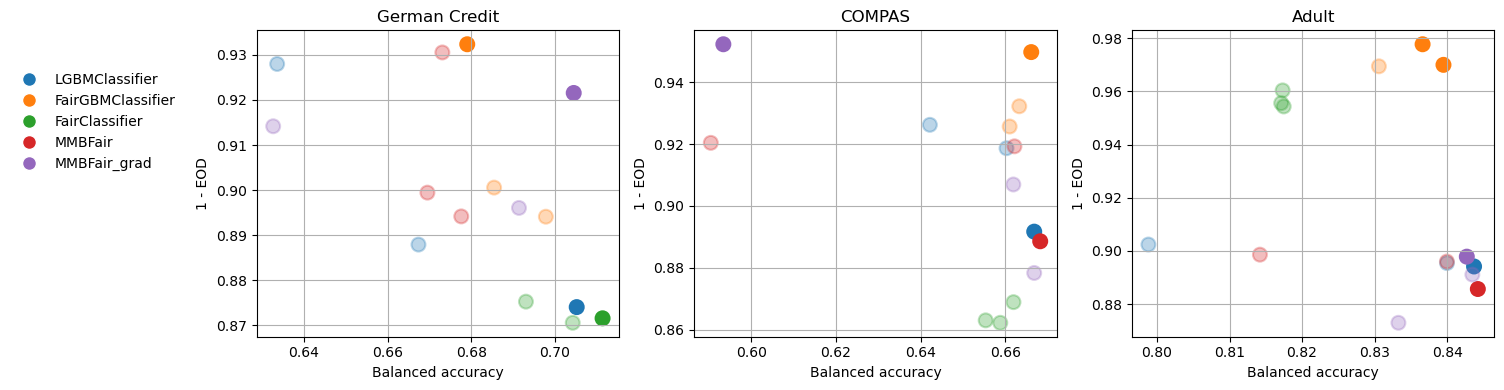

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "FairClassifier", "MMBFair", "MMBFair_grad"]



for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        try:
            df = pd.read_csv(model + "/results.csv")
            df["model"] = model_name
            df["fair"] = 1 - abs(df["eod"])
            df = df[["model", "bal_acc", "fair"]]
            df = df.groupby("model").mean().reset_index()
            results.append(df)
        except:
            continue
        

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(
            df["bal_acc"], 
            df["fair"], 
            label=model,
            alpha = [0.3 if dominated else 1 for dominated in df["dominated"]], 
            s = 100,
            lw = 1.5
        )

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[k].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
        #axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

In [4]:
for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*0.7")
    results_mean = []
    results_std = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])

        df = pd.read_csv(model + "/results.csv").iloc[:, 1:]
        df["model"] = model_name
        df["fair"] = 1 - abs(df["eod"])
        df = df[["model", "bal_acc", "fair"]]
        df_mean = df.groupby("model").mean().reset_index()
        df_std = df.groupby("model").std().reset_index()

        results_mean.append(df_mean)
        results_std.append(df_std)
    
    results_mean = pd.concat(results_mean).reset_index(drop=True).round(3)
    results_std = pd.concat(results_std).reset_index(drop=True).round(3)

    results_mean["bal_acc"] = results_mean["bal_acc"].astype(str) + " ± " + results_std["bal_acc"].astype(str)
    results_mean["fair"] = results_mean["fair"].astype(str) + " ± " + results_std["fair"].astype(str)

    print(dataset_names[dataset])
    print(results_mean)
    print("\n\n")

    

German Credit
               model        bal_acc           fair
0     LGBMClassifier  0.667 ± 0.032  0.888 ± 0.097
1  FairGBMClassifier  0.685 ± 0.046  0.901 ± 0.069
2     FairClassifier  0.704 ± 0.041  0.871 ± 0.101
3            MMBFair  0.678 ± 0.037  0.894 ± 0.095
4       MMBFair_grad   0.691 ± 0.04  0.896 ± 0.107



COMPAS
               model        bal_acc           fair
0     LGBMClassifier    0.66 ± 0.02  0.919 ± 0.054
1  FairGBMClassifier  0.661 ± 0.017  0.926 ± 0.056
2     FairClassifier  0.659 ± 0.014  0.862 ± 0.031
3            MMBFair  0.662 ± 0.019  0.919 ± 0.062
4       MMBFair_grad  0.662 ± 0.018  0.907 ± 0.061



Adult
               model        bal_acc           fair
0     LGBMClassifier   0.84 ± 0.004  0.895 ± 0.036
1  FairGBMClassifier  0.837 ± 0.004  0.978 ± 0.016
2     FairClassifier  0.817 ± 0.004   0.956 ± 0.04
3            MMBFair   0.84 ± 0.006  0.896 ± 0.035
4       MMBFair_grad  0.843 ± 0.005  0.898 ± 0.039





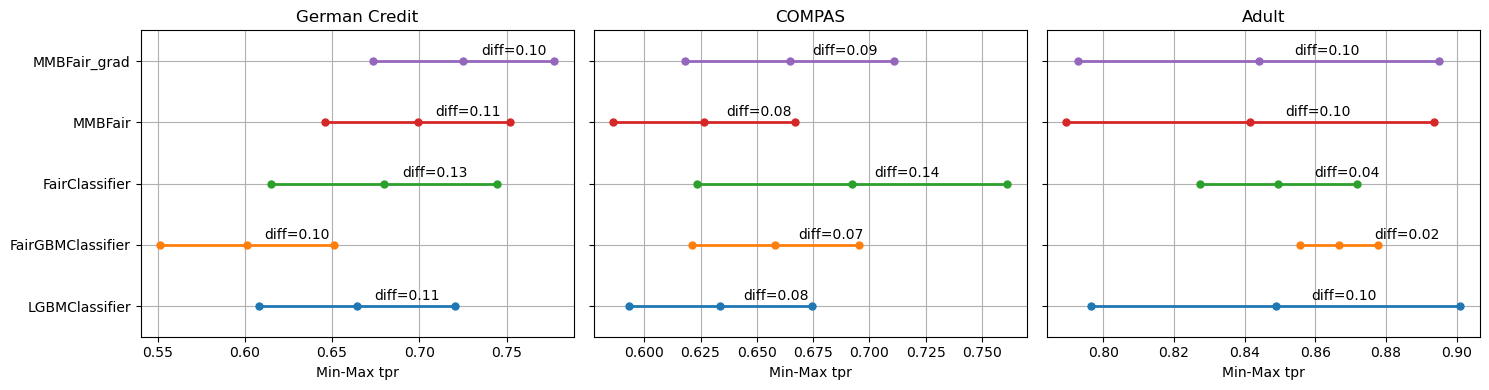

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4), sharey=True)
metric = "tpr"
selected_models = ["LGBMClassifier", "FairGBMClassifier", "FairClassifier", "MMBFair", "MMBFair_grad"]
for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*0.7")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df = df.groupby("model").mean().reset_index()
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=2, marker="o", markersize=5)
        # annotate the difference above the line
        axs[k].annotate(f"diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.01, i + 0.1), fontsize=10)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel(f"Min-Max {metric}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels(selected_models)
   
plt.tight_layout()

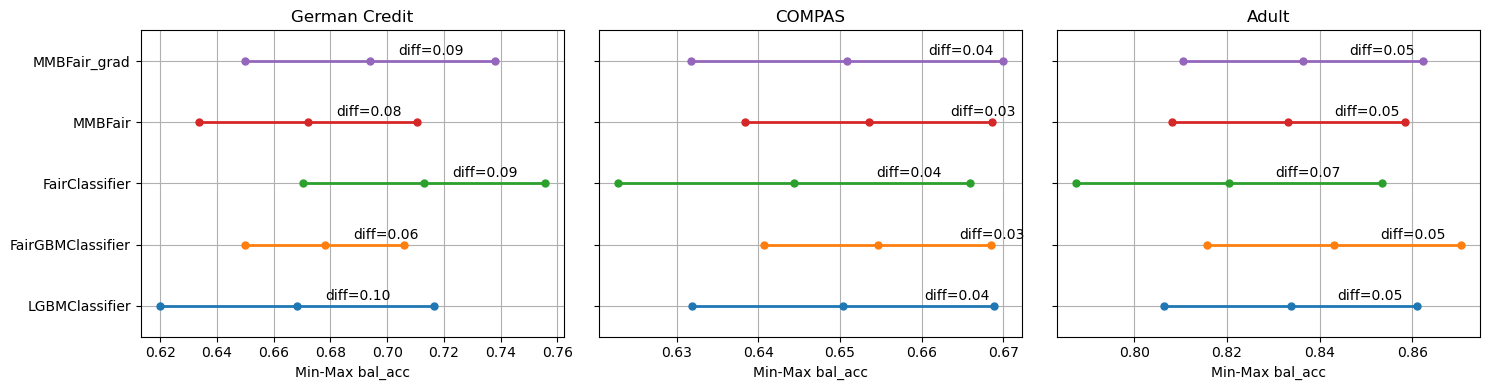

In [6]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4), sharey=True)
metric = "bal_acc"
selected_models = ["LGBMClassifier", "FairGBMClassifier", "FairClassifier", "MMBFair", "MMBFair_grad"]
for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*0.7")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df = df.groupby("model").mean().reset_index()
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=2, marker="o", markersize=5)
        # annotate the difference above the line
        axs[k].annotate(f"diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.01, i + 0.1), fontsize=10)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel(f"Min-Max {metric}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels(selected_models)
   
plt.tight_layout()

## Experiment 2

In [14]:
handles = [
    Line2D([0], [0], marker='o', color='w', label='LGBMClassifier', markerfacecolor='C0', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='FairGBMClassifier', markerfacecolor='C1', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MMBFair', markerfacecolor='C2', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MMBFair_grad', markerfacecolor='C3', markersize=10),
]

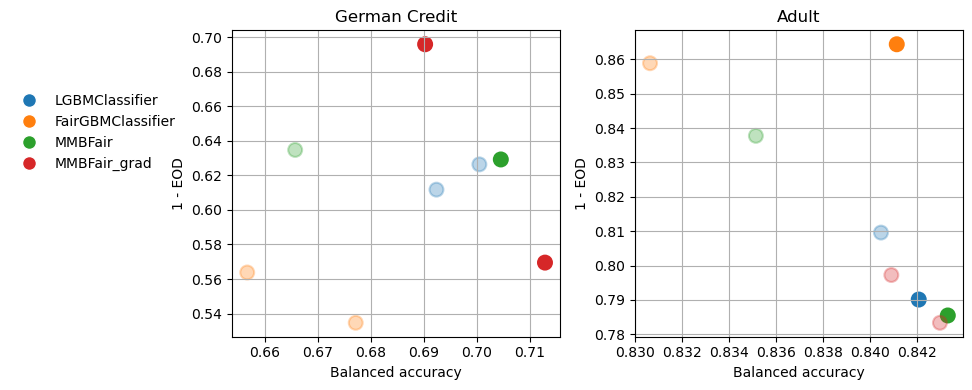

In [16]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]


for k, dataset in enumerate(["german", "adult"]):
    # load tables
    models = glob.glob(f"../results/subgroup_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        try:
            df = pd.read_csv(model + "/results.csv")
            df["model"] = model_name
            df["fair"] = 1 - abs(df["eod"])
            df = df[["model", "bal_acc", "fair"]]
            df = df.groupby("model").mean().reset_index()
            results.append(df)
        except:
            continue
        

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(
            df["bal_acc"], 
            df["fair"], 
            label=model,
            alpha = [0.3 if dominated else 1 for dominated in df["dominated"]],
            s = 100,
            lw = 1.5
        )


    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[k].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

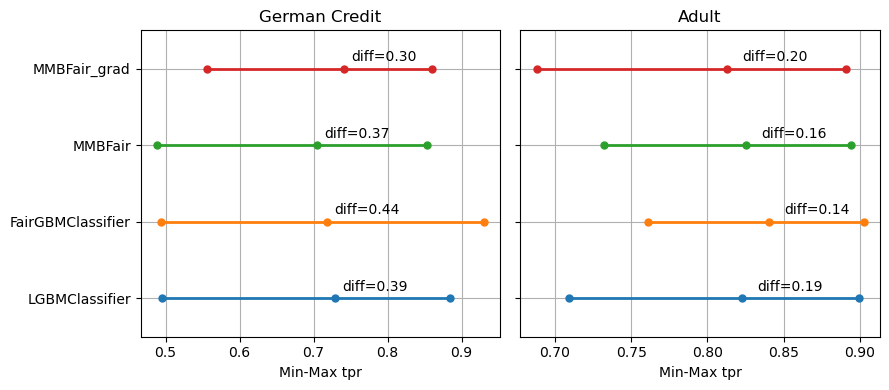

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4), sharey=True)
metric = "tpr"
selected_models = ["LGBMClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]
for k, dataset in enumerate(["german", "adult"]):
    # load tables
    models = glob.glob(f"../results/subgroup_experiment/{dataset}/*0.75")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df = df.groupby("model").mean().reset_index()
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=2, marker="o", markersize=5)
        # annotate the difference above the line
        axs[k].annotate(f"diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.01, i + 0.1), fontsize=10)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel(f"Min-Max {metric}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels(selected_models)
   
plt.tight_layout()

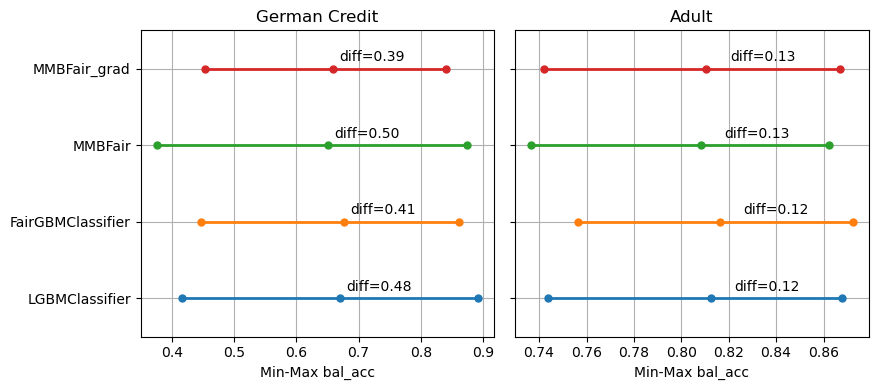

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4), sharey=True)
metric = "bal_acc"
selected_models = ["LGBMClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]
for k, dataset in enumerate(["german", "adult"]):
    # load tables
    models = glob.glob(f"../results/subgroup_experiment/{dataset}/*0.75")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df = df.groupby("model").mean().reset_index()
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=2, marker="o", markersize=5)
        # annotate the difference above the line
        axs[k].annotate(f"diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.01, i + 0.1), fontsize=10)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel(f"Min-Max {metric}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels(selected_models)
   
plt.tight_layout()

## Experiment 4

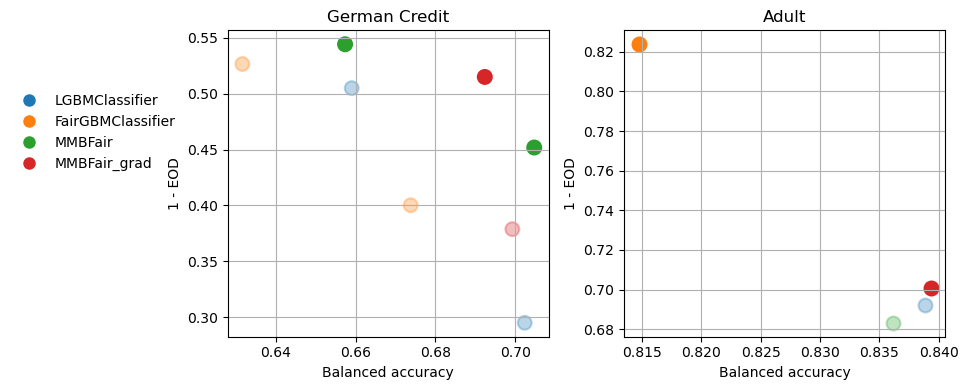

In [18]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]


for k, dataset in enumerate(["german", "adult"]):
    # load tables
    models = glob.glob(f"../results/subgroup2_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        try:
            df = pd.read_csv(model + "/results.csv")
            df["model"] = model_name
            df["fair"] = 1 - abs(df["eod"])
            df = df[["model", "bal_acc", "fair"]]
            df = df.groupby("model").mean().reset_index()
            results.append(df)
        except:
            continue
        

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(
            df["bal_acc"], 
            df["fair"], 
            label=model,
            alpha = [0.3 if dominated else 1 for dominated in df["dominated"]],  
            s = 100,
            lw = 1.5
        )

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[k].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

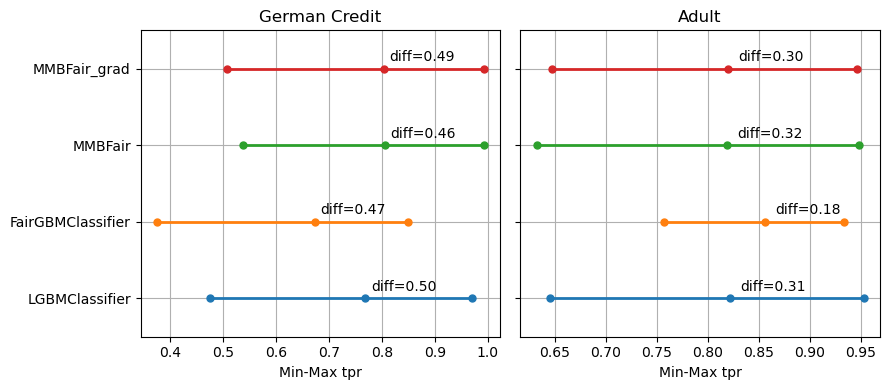

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4), sharey=True)
metric = "tpr"
selected_models = ["LGBMClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]
for k, dataset in enumerate(["german", "adult"]):
    # load tables
    models = glob.glob(f"../results/subgroup2_experiment/{dataset}/*0.75")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df = df.groupby("model").mean().reset_index()
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=2, marker="o", markersize=5)
        # annotate the difference above the line
        axs[k].annotate(f"diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.01, i + 0.1), fontsize=10)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel(f"Min-Max {metric}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels(selected_models)
   
plt.tight_layout()